# Машинный перевод. Модель seq2seq и механизм внимания

запустить для перевода с русского на английский (при желании можно взять другие пары языков) два варианта с вниманием и без внимания
оценить качество насколько корректно переводит (для теста отобрать примеры с увеличением длины текста) (так как оценка визуальная достаточно 20-ти примеров в тестовой выборке)

In [14]:
# Импорт библиотек

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [19]:
# Загрузка данных

path_to_file = "./rus-eng/rus.txt"

In [20]:
# Функция препроцессинг текста

def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [21]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [23]:
en, ru = create_dataset(path_to_file, None)
print(en[100])
print(ru[100])

<start> eat it . <end>
<start> съешьте это . <end>


In [24]:
# Токенизация

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [25]:
# Создание датасета

def load_dataset(path, num_examples=None):

  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [27]:
# Размер датасета

len(ru)

444587

In [28]:
# Эксперементируем с размером датасета
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Вычисляем максимальную длинну целевого тензора
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [29]:
# Разбиваем датасет на тренировочную и валидационные выборки (80/20)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Длина тензора
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [30]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [31]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> том
11139 ----> зашнуровал
525 ----> ботинки
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
3544 ----> laced
97 ----> his
401 ----> shoes
3 ----> .
2 ----> <end>


In [32]:
# Создание tensorflow датасета

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

Metal device set to: Apple M1


2022-06-15 15:31:40.586308: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-15 15:31:40.587826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [33]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [34]:
# Энкодер

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=False,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [35]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_hidden = encoder(example_input_batch, sample_hidden)
# print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)


In [36]:
# Декодер

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

  def call(self, x, hidden):
    # enc_output shape == (batch_size, max_length, hidden_size)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state=hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state

In [37]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden)



In [39]:
# Оптимизатор и лосс-функция

optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [40]:
# Создание чекпоинтов

!rm -rf ./training_checkpoints

checkpoint_dir = './training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [41]:
# Обучение

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden = decoder(dec_input, dec_hidden)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [42]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2022-06-15 15:35:37.664024: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-15 15:35:37.684823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-15 15:35:38.466534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-15 15:35:38.645029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-15 15:35:38.703421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-15 15:35:39.154140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-15 15:35:39.180489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

Epoch 1 Batch 0 Loss 4.7406
Epoch 1 Batch 100 Loss 2.0685
Epoch 1 Batch 200 Loss 1.7896
Epoch 1 Batch 300 Loss 1.6314
Epoch 1 Batch 400 Loss 1.5157
Epoch 1 Batch 500 Loss 1.4102
Epoch 1 Batch 600 Loss 1.4226
Epoch 1 Batch 700 Loss 1.2598
Epoch 1 Batch 800 Loss 1.2732
Epoch 1 Batch 900 Loss 1.1210
Epoch 1 Batch 1000 Loss 1.1623
Epoch 1 Batch 1100 Loss 0.9969
Epoch 1 Batch 1200 Loss 1.0126
Epoch 1 Loss 1.4632
Time taken for 1 epoch 273.06112003326416 sec

Epoch 2 Batch 0 Loss 0.8908
Epoch 2 Batch 100 Loss 0.8870
Epoch 2 Batch 200 Loss 0.8123
Epoch 2 Batch 300 Loss 0.8096
Epoch 2 Batch 400 Loss 0.7949
Epoch 2 Batch 500 Loss 0.8025
Epoch 2 Batch 600 Loss 0.7427
Epoch 2 Batch 700 Loss 0.8065
Epoch 2 Batch 800 Loss 0.6315
Epoch 2 Batch 900 Loss 0.7842
Epoch 2 Batch 1000 Loss 0.6379
Epoch 2 Batch 1100 Loss 0.6968
Epoch 2 Batch 1200 Loss 0.6324
Epoch 2 Loss 0.7665
Time taken for 1 epoch 266.73529601097107 sec

Epoch 3 Batch 0 Loss 0.5337
Epoch 3 Batch 100 Loss 0.4991
Epoch 3 Batch 200 Loss 0.5

Epoch 18 Batch 1000 Loss 0.2572
Epoch 18 Batch 1100 Loss 0.2068
Epoch 18 Batch 1200 Loss 0.2433
Epoch 18 Loss 0.1956
Time taken for 1 epoch 271.53600096702576 sec

Epoch 19 Batch 0 Loss 0.1597
Epoch 19 Batch 100 Loss 0.1892
Epoch 19 Batch 200 Loss 0.2615
Epoch 19 Batch 300 Loss 0.2213
Epoch 19 Batch 400 Loss 0.1869
Epoch 19 Batch 500 Loss 0.1847
Epoch 19 Batch 600 Loss 0.2169
Epoch 19 Batch 700 Loss 0.2229
Epoch 19 Batch 800 Loss 0.1610
Epoch 19 Batch 900 Loss 0.2480
Epoch 19 Batch 1000 Loss 0.2281
Epoch 19 Batch 1100 Loss 0.1840
Epoch 19 Batch 1200 Loss 0.2383
Epoch 19 Loss 0.2014
Time taken for 1 epoch 268.3031198978424 sec

Epoch 20 Batch 0 Loss 0.1827
Epoch 20 Batch 100 Loss 0.1846
Epoch 20 Batch 200 Loss 0.2296
Epoch 20 Batch 300 Loss 0.1669
Epoch 20 Batch 400 Loss 0.1857
Epoch 20 Batch 500 Loss 0.1805
Epoch 20 Batch 600 Loss 0.1883
Epoch 20 Batch 700 Loss 0.2022
Epoch 20 Batch 800 Loss 0.2101
Epoch 20 Batch 900 Loss 0.2260
Epoch 20 Batch 1000 Loss 0.2684
Epoch 20 Batch 1100 Loss 

Epoch 36 Batch 100 Loss 0.2839
Epoch 36 Batch 200 Loss 0.3028
Epoch 36 Batch 300 Loss 0.2423
Epoch 36 Batch 400 Loss 0.2253
Epoch 36 Batch 500 Loss 0.3116
Epoch 36 Batch 600 Loss 0.3748
Epoch 36 Batch 700 Loss 0.3487
Epoch 36 Batch 800 Loss 0.3743
Epoch 36 Batch 900 Loss 0.3424
Epoch 36 Batch 1000 Loss 0.3213
Epoch 36 Batch 1100 Loss 0.3007
Epoch 36 Batch 1200 Loss 0.3549
Epoch 36 Loss 0.3117
Time taken for 1 epoch 266.700407743454 sec

Epoch 37 Batch 0 Loss 0.2644
Epoch 37 Batch 100 Loss 0.3140
Epoch 37 Batch 200 Loss 0.2331
Epoch 37 Batch 300 Loss 0.2646
Epoch 37 Batch 400 Loss 0.2949
Epoch 37 Batch 500 Loss 0.3955
Epoch 37 Batch 600 Loss 0.2955
Epoch 37 Batch 700 Loss 0.3078
Epoch 37 Batch 800 Loss 0.3303
Epoch 37 Batch 900 Loss 0.3242
Epoch 37 Batch 1000 Loss 0.3990
Epoch 37 Batch 1100 Loss 0.3137
Epoch 37 Batch 1200 Loss 0.4981
Epoch 37 Loss 0.3172
Time taken for 1 epoch 264.8156328201294 sec

Epoch 38 Batch 0 Loss 0.2410
Epoch 38 Batch 100 Loss 0.2927
Epoch 38 Batch 200 Loss 0.33

In [48]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input, dec_hidden)

    # storing the attention weights to plot later on
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [49]:
def translate(sentence):
  result, sentence = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

In [50]:
# Восстанавливаем последний чекпоинт
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [63]:
# Тестируем

test_text = ['Без труда не выловишь и рыбку из пруда', 'Сделал дело - гуляй смело', 
             'Не откладывай на завтра то, что можешь сделать сегодня', 'мама мыла окно',  
            'Маленькой ели холодно зимой', 'мы идем гулять по лесу', 'как мне пройти в библиотеку?']

for text in test_text:
    translate(text)

Input: <start> без труда не выловишь и рыбку из пруда <end>
Predicted translation: no pain , no gain ! <end> 
Input: <start> сделал дело гуляй смело <end>
Predicted translation: finish the job . <end> 
Input: <start> не откладывай на завтра то , что можешь сделать сегодня <end>
Predicted translation: don't go to my son . <end> 
Input: <start> мама мыла окно <end>
Predicted translation: have a nice trip . <end> 
Input: <start> маленькой ели холодно зимой <end>
Predicted translation: do it for you . <end> 
Input: <start> мы идем гулять по лесу <end>
Predicted translation: we have fun with them . <end> 
Input: <start> как мне пройти в библиотеку ? <end>
Predicted translation: how's your job ? <end> 


Даже рассмотрев всего несколько предложений видно, что перевод получился совсем слабым, при этом словарь у модели ограничен и если встречается незнакомое слово, модель отказывается осуществлять перевод.

## Attention 

In [64]:
# Энкодер

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [65]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [66]:
# Attention

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [67]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [68]:
# Декодер

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [69]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7334)


In [70]:
# Оптимайзер и лосс функция

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [71]:
# Чекпоинты

!rm -rf ./training_attention_checkpoints

checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [72]:
# Обучение

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [73]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2022-06-15 20:26:48.180887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-15 20:26:49.139390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-15 20:26:49.298235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-15 20:26:49.356956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-15 20:26:49.425348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-15 20:26:49.489669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-15 20:26:49.555391: I tensorflow/core/grappler/optimizers/cust

Epoch 1 Batch 0 Loss 4.6779
Epoch 1 Batch 100 Loss 2.1548
Epoch 1 Batch 200 Loss 1.9249
Epoch 1 Batch 300 Loss 1.7156
Epoch 1 Batch 400 Loss 1.5893
Epoch 1 Batch 500 Loss 1.5013
Epoch 1 Batch 600 Loss 1.3852
Epoch 1 Batch 700 Loss 1.2965
Epoch 1 Batch 800 Loss 1.1955
Epoch 1 Batch 900 Loss 1.1048
Epoch 1 Batch 1000 Loss 1.1152
Epoch 1 Batch 1100 Loss 1.0348
Epoch 1 Batch 1200 Loss 1.0391
Epoch 1 Loss 1.5027
Time taken for 1 epoch 453.89902997016907 sec

Epoch 2 Batch 0 Loss 0.8786
Epoch 2 Batch 100 Loss 0.8504
Epoch 2 Batch 200 Loss 0.8218
Epoch 2 Batch 300 Loss 0.7662
Epoch 2 Batch 400 Loss 0.8363
Epoch 2 Batch 500 Loss 0.6544
Epoch 2 Batch 600 Loss 0.7394
Epoch 2 Batch 700 Loss 0.7562
Epoch 2 Batch 800 Loss 0.6100
Epoch 2 Batch 900 Loss 0.7008
Epoch 2 Batch 1000 Loss 0.5285
Epoch 2 Batch 1100 Loss 0.5231
Epoch 2 Batch 1200 Loss 0.6018
Epoch 2 Loss 0.7370
Time taken for 1 epoch 437.7915551662445 sec

Epoch 3 Batch 0 Loss 0.4475
Epoch 3 Batch 100 Loss 0.4972
Epoch 3 Batch 200 Loss 0.43

Epoch 18 Batch 1000 Loss 0.1222
Epoch 18 Batch 1100 Loss 0.1044
Epoch 18 Batch 1200 Loss 0.1185
Epoch 18 Loss 0.1048
Time taken for 1 epoch 435.15171098709106 sec

Epoch 19 Batch 0 Loss 0.0793
Epoch 19 Batch 100 Loss 0.0671
Epoch 19 Batch 200 Loss 0.0784
Epoch 19 Batch 300 Loss 0.0950
Epoch 19 Batch 400 Loss 0.1121
Epoch 19 Batch 500 Loss 0.1188
Epoch 19 Batch 600 Loss 0.1185
Epoch 19 Batch 700 Loss 0.1284
Epoch 19 Batch 800 Loss 0.1118
Epoch 19 Batch 900 Loss 0.1108
Epoch 19 Batch 1000 Loss 0.1427
Epoch 19 Batch 1100 Loss 0.1349
Epoch 19 Batch 1200 Loss 0.1368
Epoch 19 Loss 0.1035
Time taken for 1 epoch 433.89416694641113 sec

Epoch 20 Batch 0 Loss 0.0821
Epoch 20 Batch 100 Loss 0.0615
Epoch 20 Batch 200 Loss 0.0833
Epoch 20 Batch 300 Loss 0.0820
Epoch 20 Batch 400 Loss 0.1272
Epoch 20 Batch 500 Loss 0.0824
Epoch 20 Batch 600 Loss 0.0975
Epoch 20 Batch 700 Loss 0.0894
Epoch 20 Batch 800 Loss 0.1202
Epoch 20 Batch 900 Loss 0.0997
Epoch 20 Batch 1000 Loss 0.0815
Epoch 20 Batch 1100 Loss

Epoch 36 Batch 100 Loss 0.0658
Epoch 36 Batch 200 Loss 0.0797
Epoch 36 Batch 300 Loss 0.0700
Epoch 36 Batch 400 Loss 0.0855
Epoch 36 Batch 500 Loss 0.0688
Epoch 36 Batch 600 Loss 0.1014
Epoch 36 Batch 700 Loss 0.1004
Epoch 36 Batch 800 Loss 0.0681
Epoch 36 Batch 900 Loss 0.0715
Epoch 36 Batch 1000 Loss 0.1012
Epoch 36 Batch 1100 Loss 0.1573
Epoch 36 Batch 1200 Loss 0.0709
Epoch 36 Loss 0.0969
Time taken for 1 epoch 443.1191899776459 sec

Epoch 37 Batch 0 Loss 0.0556
Epoch 37 Batch 100 Loss 0.0778
Epoch 37 Batch 200 Loss 0.0724
Epoch 37 Batch 300 Loss 0.1082
Epoch 37 Batch 400 Loss 0.1095
Epoch 37 Batch 500 Loss 0.1154
Epoch 37 Batch 600 Loss 0.1195
Epoch 37 Batch 700 Loss 0.0746
Epoch 37 Batch 800 Loss 0.0920
Epoch 37 Batch 900 Loss 0.1307
Epoch 37 Batch 1000 Loss 0.0865
Epoch 37 Batch 1100 Loss 0.1019
Epoch 37 Batch 1200 Loss 0.0804
Epoch 37 Loss 0.0979
Time taken for 1 epoch 439.100652217865 sec

Epoch 38 Batch 0 Loss 0.0802
Epoch 38 Batch 100 Loss 0.0833
Epoch 38 Batch 200 Loss 0.08

In [74]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [75]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [76]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> без труда не выловишь и рыбку из пруда <end>
Predicted translation: no pain , isn't here . <end> 


/var/folders/zn/6rz5gp7s0h702g118wcbvmkh0000gn/T/ipykernel_29402/282331986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/zn/6rz5gp7s0h702g118wcbvmkh0000gn/T/ipykernel_29402/282331986.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


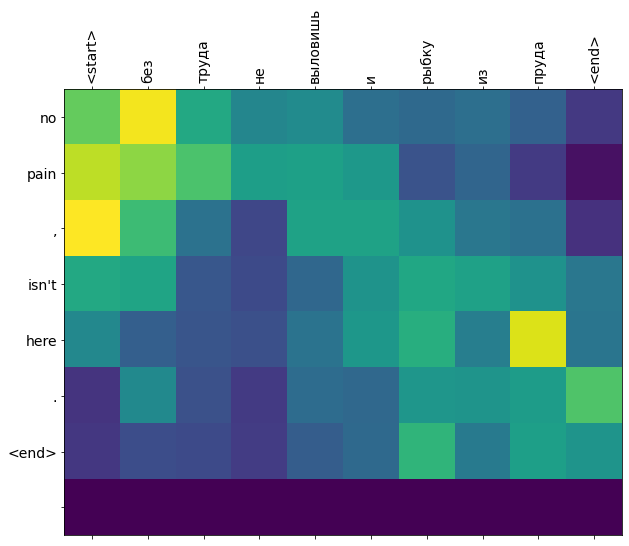

Input: <start> сделал дело гуляй смело <end>
Predicted translation: really started to it . <end> 


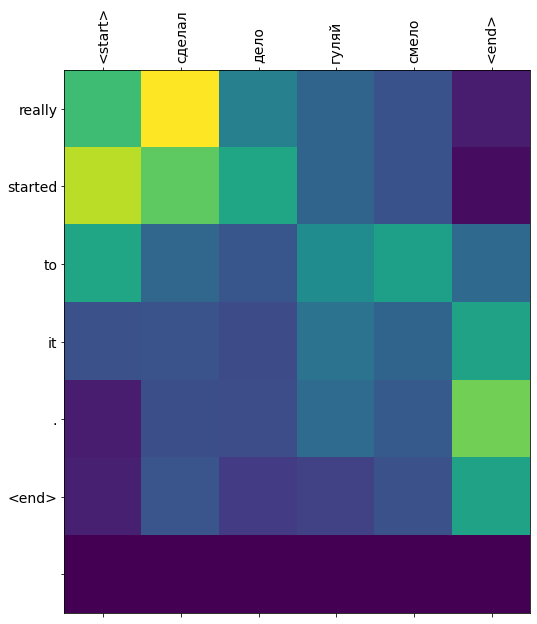

Input: <start> не откладывай на завтра то , что можешь сделать сегодня <end>
Predicted translation: it be excused ? <end> 


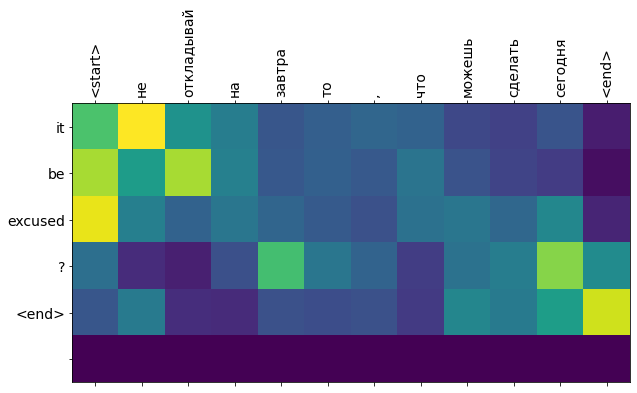

Input: <start> мама мыла окно <end>
Predicted translation: mom is a horse . <end> 


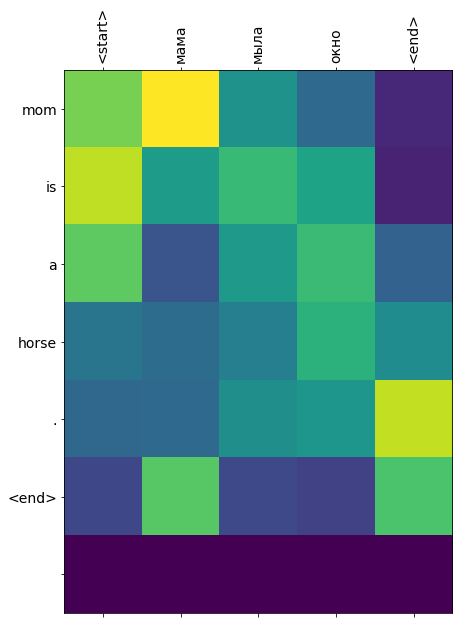

Input: <start> маленькой ели холодно зимой <end>
Predicted translation: no one food was food . <end> 


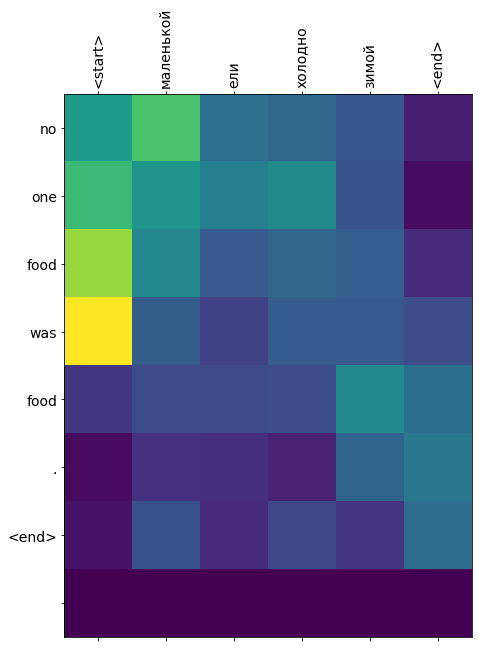

Input: <start> мы идем гулять по лесу <end>
Predicted translation: we walked near a bit . <end> 


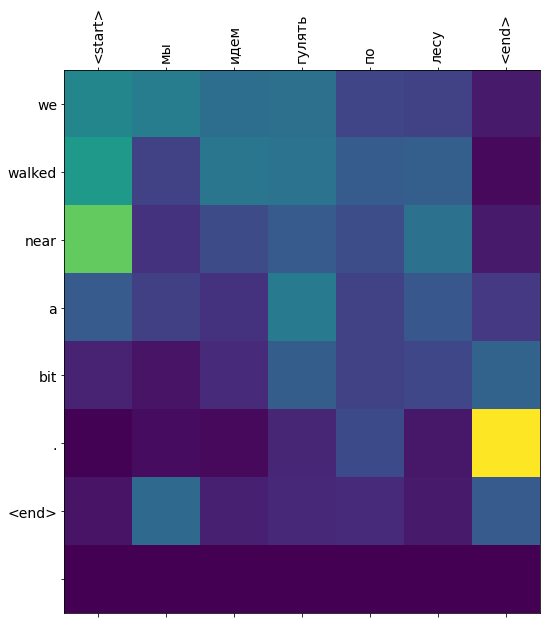

Input: <start> как мне пройти в библиотеку ? <end>
Predicted translation: how do the go with me ? <end> 


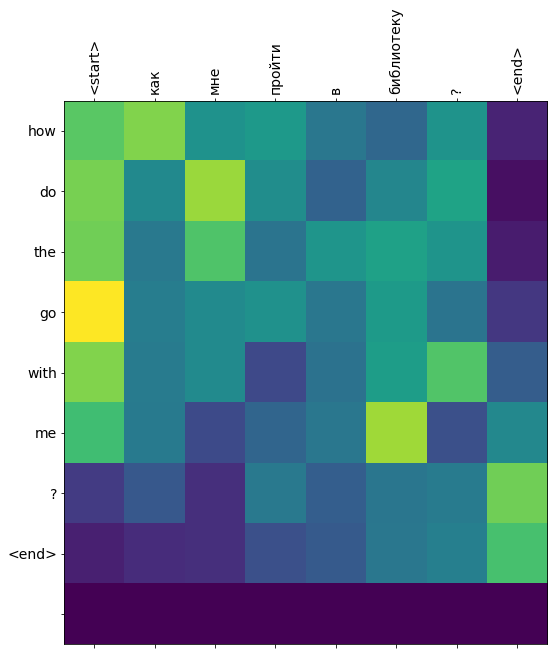

In [77]:
# Тестируем

test_text = ['Без труда не выловишь и рыбку из пруда', 'Сделал дело - гуляй смело', 
             'Не откладывай на завтра то, что можешь сделать сегодня', 'мама мыла окно',  
            'Маленькой ели холодно зимой', 'мы идем гулять по лесу', 'как мне пройти в библиотеку?']

for text in test_text:
    translate(text)

Перевод сетью с вниманием получился еще хуже.